PRODUCT-MARKET FIT ANALYSIS

Dataset: 386,038 transactions
Unique Customers: 4,337
Unique Products: 3,575
Date range: 2010-12-01 to 2011-12-09

✅ Loaded RFM segments: 4,337 customers

Total customers: 4,337
Repeat customers: 2,835 (65.4%)
One-time customers: 1,502 (34.6%)

FIRST PURCHASE ANALYSIS

=== TOP 10: First Purchase Products (Repeat Customers) ===
Description
WHITE HANGING HEART T-LIGHT HOLDER    410
REGENCY CAKESTAND 3 TIER              370
ASSORTED COLOUR BIRD ORNAMENT         281
JAM MAKING SET WITH JARS              252
SET OF 3 CAKE TINS PANTRY DESIGN      241
JUMBO BAG RED RETROSPOT               237
JAM MAKING SET PRINTED                236
PARTY BUNTING                         235
PACK OF 72 RETROSPOT CAKE CASES       234
NATURAL SLATE HEART CHALKBOARD        225
dtype: int64

=== TOP 10: First Purchase Products (One-Time Customers) ===
Description
WHITE HANGING HEART T-LIGHT HOLDER    165
REGENCY CAKESTAND 3 TIER              145
REX CASH+CARRY JUMBO SHOPPER          1

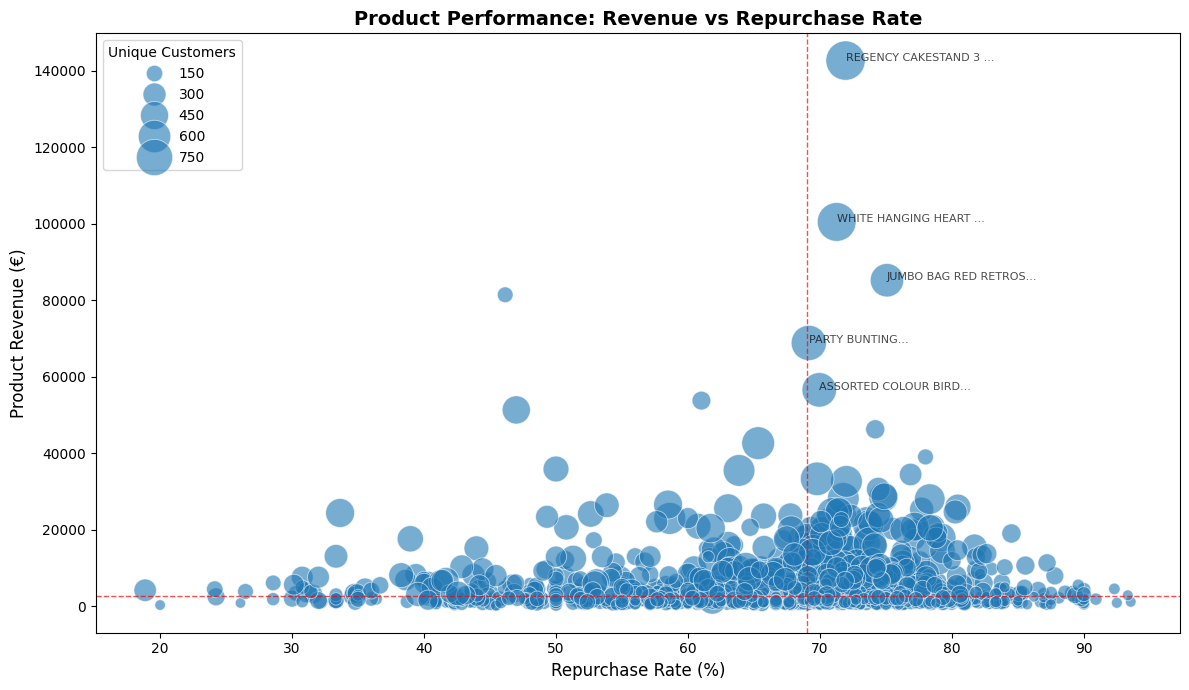

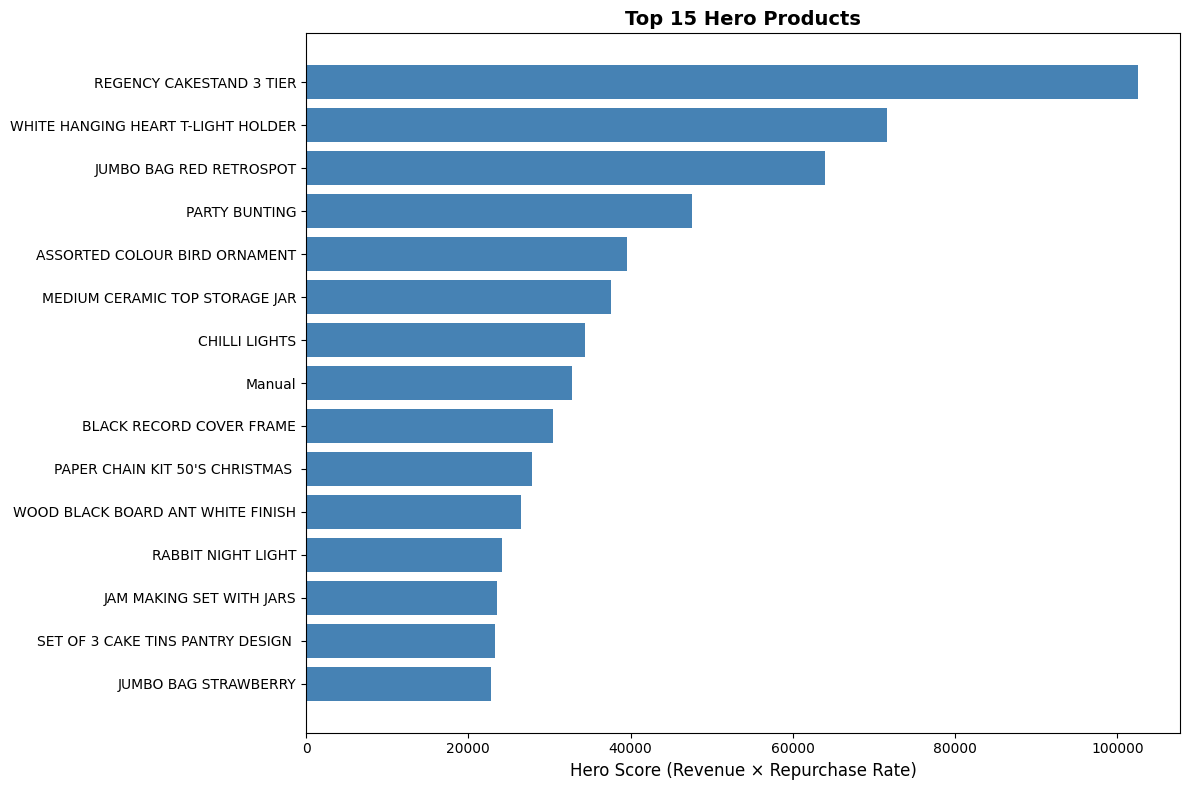


CROSS-NOTEBOOK INSIGHTS

=== HERO PRODUCT ADOPTION BY COHORT ===
Cohort 2010-12: 79.5% bought at least one hero product
Rest cohorts:   64.4%
Difference:     +15.1pp

=== HERO PRODUCT PENETRATION BY SEGMENT ===
Segment
Champions   91.50
Loyal       81.70
Potential   79.10
At-Risk     66.10
Lost        51.70
New         45.10
Name: CustomerID, dtype: float64

📊 PRODUCT-MARKET FIT ANALYSIS - COMPLETED

KEY METRICS:
• Total products analyzed: 3,781
• Average repurchase rate (eligible products): 66.8%
• Hero products identified: 15
• Hero product revenue contribution: €899,374 (10.5% of total revenue)

KEY FINDINGS:
1. Hero products (top 15) combine high revenue and high repurchase rates.
2. Cohort 2010-12 has 1.2x higher hero product adoption.
3. Champions segment shows hero product penetration of 91.5% vs 51.7% for Lost.
4. Product differentiation exists: Champions and At-Risk buy different product mixes.

IMPLICATIONS:
→ Priority #1: Push hero products in onboarding flows to mimic 2010

In [1]:
# ============================================================================
# 03. PRODUCT-MARKET FIT ANALYSIS
# Business question: Which products drive retention and high-value customers?
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Format
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# ============================================================================
## 1. DATA LOADING & PREPARATION
# ============================================================================

print('='*70)
print('PRODUCT-MARKET FIT ANALYSIS')
print('='*70)

# Load clean data
retail_clean = pd.read_csv('online_retail_clean.csv', parse_dates=['InvoiceDate'])

print(f'\nDataset: {len(retail_clean):,} transactions')
print(f'Unique Customers: {retail_clean["CustomerID"].nunique():,}')
print(f'Unique Products: {retail_clean["StockCode"].nunique():,}')
print(f'Date range: {retail_clean["InvoiceDate"].min().date()} to {retail_clean["InvoiceDate"].max().date()}')

# Load RFM segments from Notebook 02
try:
    rfm_segments = pd.read_csv('rfm_segments.csv')
    print(f'\n✅ Loaded RFM segments: {len(rfm_segments):,} customers')
except FileNotFoundError:
    print('\n⚠️ RFM segments file not found. Recalculating...')
    reference_date = retail_clean['InvoiceDate'].max() + pd.Timedelta(days=1)
    rfm_segments = retail_clean.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (reference_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'Revenue': 'sum'
    }).reset_index()
    rfm_segments.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    rfm_segments = rfm_segments[rfm_segments['Monetary'] > 0]
    
    rfm_segments['R_score'] = pd.cut(rfm_segments['Recency'], bins=5, labels=[5,4,3,2,1])
    rfm_segments['F_score'] = pd.cut(rfm_segments['Frequency'], bins=5, labels=[1,2,3,4,5])
    rfm_segments['M_score'] = pd.cut(rfm_segments['Monetary'], bins=5, labels=[1,2,3,4,5])
    rfm_segments['R_score'] = rfm_segments['R_score'].astype(int)
    rfm_segments['F_score'] = rfm_segments['F_score'].astype(int)
    rfm_segments['M_score'] = rfm_segments['M_score'].astype(int)
    
    def rfm_segment(row):
        R, F, M = row['R_score'], row['F_score'], row['M_score']
        if R >= 4 and F >= 4 and M >= 4:
            return 'Champions'
        elif F >= 4 and M >= 3:
            return 'Loyal'
        elif R >= 3 and F >= 2 and M >= 3:
            return 'Potential'
        elif R <= 2 and F >= 3:
            return 'At-Risk'
        elif R >= 4 and F == 1:
            return 'New'
        else:
            return 'Lost'
    
    rfm_segments['Segment'] = rfm_segments.apply(rfm_segment, axis=1)
    rfm_segments['CLV'] = rfm_segments['Monetary']

# Customer-level metrics
customer_metrics = retail_clean.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'InvoiceDate': ['min', 'max']
}).reset_index()
customer_metrics.columns = ['CustomerID', 'Frequency', 'First_Purchase', 'Last_Purchase']
customer_metrics['Is_Repeat'] = customer_metrics['Frequency'] > 1

print(f'\nTotal customers: {len(customer_metrics):,}')
print(f'Repeat customers: {customer_metrics["Is_Repeat"].sum():,} ({customer_metrics["Is_Repeat"].mean()*100:.1f}%)')
print(f'One-time customers: {(~customer_metrics["Is_Repeat"]).sum():,} ({(~customer_metrics["Is_Repeat"]).mean()*100:.1f}%)')

# Merge for analysis
retail_analysis = retail_clean.merge(customer_metrics, on='CustomerID', how='left')

# ============================================================================
## 2. FIRST PURCHASE PRODUCTS: Repeat vs One-Time Customers
# ============================================================================

print('\n' + '='*70)
print('FIRST PURCHASE ANALYSIS')
print('='*70)

retail_analysis['Purchase_Rank'] = (
    retail_analysis.groupby('CustomerID')['InvoiceDate']
    .rank(method='dense')
)
first_purchases = retail_analysis[retail_analysis['Purchase_Rank'] == 1]

repeat_first = (
    first_purchases[first_purchases['Is_Repeat']]
    .groupby('Description')
    .size()
    .sort_values(ascending=False)
    .head(10)
)

onetime_first = (
    first_purchases[~first_purchases['Is_Repeat']]
    .groupby('Description')
    .size()
    .sort_values(ascending=False)
    .head(10)
)

print('\n=== TOP 10: First Purchase Products (Repeat Customers) ===')
print(repeat_first)

print('\n=== TOP 10: First Purchase Products (One-Time Customers) ===')
print(onetime_first)

repeat_set = set(repeat_first.index)
onetime_set = set(onetime_first.index)
overlap = repeat_set.intersection(onetime_set)

print(f'\n📊 OVERLAP: {len(overlap)} products appear in both Top 10 lists')
if overlap:
    print(f'   Common products: {list(overlap)[:3]}...')

# ============================================================================
## 3. REPURCHASE RATE BY PRODUCT
# ============================================================================

print('\n' + '='*70)
print('PRODUCT REPURCHASE ANALYSIS')
print('='*70)

product_first_buyers = (
    first_purchases.groupby('Description')['CustomerID']
    .nunique()
    .rename('first_buyers')
)

repeat_buyers = (
    first_purchases[first_purchases['Is_Repeat']]
    .groupby('Description')['CustomerID']
    .nunique()
    .rename('repeat_buyers')
)

repurchase_analysis = pd.concat([product_first_buyers, repeat_buyers], axis=1).fillna(0)
repurchase_analysis['repurchase_rate'] = (
    repurchase_analysis['repeat_buyers'] / repurchase_analysis['first_buyers'] * 100
).round(2)

repurchase_filtered = repurchase_analysis[repurchase_analysis['first_buyers'] >= 20]
repurchase_filtered = repurchase_filtered.sort_values('repurchase_rate', ascending=False)

print(f'\nProducts analyzed: {len(repurchase_analysis):,}')
print(f'Products with ≥20 first buyers: {len(repurchase_filtered):,}')

print('\n=== TOP 10: Highest Repurchase Rate (min 20 buyers) ===')
print(repurchase_filtered.head(10))

print('\n=== BOTTOM 10: Lowest Repurchase Rate (min 20 buyers) ===')
print(repurchase_filtered.tail(10))

# ============================================================================
## 4. PRODUCT × SEGMENT INSIGHT (CLV USE ONLY FOR PROFILE)
# ============================================================================

print('\n' + '='*70)
print('PRODUCT PURCHASE BY CUSTOMER SEGMENT')
print('='*70)

product_clv = retail_analysis.merge(
    rfm_segments[['CustomerID', 'CLV', 'Segment']], 
    on='CustomerID', 
    how='left'
)

champions_products = (
    product_clv[product_clv['Segment'] == 'Champions']
    .groupby('Description')
    .size()
    .sort_values(ascending=False)
    .head(10)
)

atrisk_products = (
    product_clv[product_clv['Segment'] == 'At-Risk']
    .groupby('Description')
    .size()
    .sort_values(ascending=False)
    .head(10)
)

print('\n=== TOP 10: Products Bought by CHAMPIONS ===')
print(champions_products)

print('\n=== TOP 10: Products Bought by AT-RISK ===')
print(atrisk_products)

champ_set = set(champions_products.index)
atrisk_set = set(atrisk_products.index)
overlap_segments = champ_set.intersection(atrisk_set)

print(f'\n📊 PRODUCT DIFFERENTIATION:')
print(f'   Champions-only products: {len(champ_set - atrisk_set)}')
print(f'   At-Risk-only products: {len(atrisk_set - champ_set)}')
print(f'   Shared products: {len(overlap_segments)}')

# ============================================================================
## 5. HERO PRODUCTS (REVENUE × REPURCHASE RATE)
# ============================================================================

print('\n' + '='*70)
print('HERO PRODUCTS IDENTIFICATION (Revenue-based)')
print('='*70)

product_stats = (
    retail_clean
    .groupby('Description')
    .agg({
        'Revenue': 'sum',
        'CustomerID': 'nunique'
    })
    .reset_index()
    .rename(columns={
        'Revenue': 'Product_Revenue',
        'CustomerID': 'Unique_Customers'
    })
)

product_analysis = product_stats.merge(
    repurchase_filtered[['first_buyers', 'repeat_buyers', 'repurchase_rate']],
    on='Description',
    how='left'
)

min_customers = 50
min_first_buyers = 20

product_analysis_filtered = product_analysis[
    (product_analysis['Unique_Customers'] >= min_customers) &
    (product_analysis['first_buyers'] >= min_first_buyers)
].copy()

print(f"\nProducts with ≥{min_customers} customers and ≥{min_first_buyers} first buyers: {len(product_analysis_filtered):,}")

product_analysis_filtered['Hero_Score'] = (
    product_analysis_filtered['Product_Revenue'] *
    (product_analysis_filtered['repurchase_rate'] / 100)
)

hero_products = (
    product_analysis_filtered
    .sort_values('Hero_Score', ascending=False)
    .head(15)
)

print('\n=== TOP 15 HERO PRODUCTS (Revenue × Repurchase Rate) ===')
print(
    hero_products[[
        'Description',
        'Product_Revenue',
        'Unique_Customers',
        'first_buyers',
        'repurchase_rate',
        'Hero_Score'
    ]]
)

hero_revenue = hero_products['Product_Revenue'].sum()
total_revenue = retail_clean['Revenue'].sum()
hero_pct = hero_revenue / total_revenue * 100

print('\n=== HERO PRODUCTS REVENUE CONTRIBUTION ===')
print(f"Total revenue (clean dataset): €{total_revenue:,.2f}")
print(f"Hero products revenue:         €{hero_revenue:,.2f}")
print(f"Hero products share:           {hero_pct:.1f}%")
print(f"Average hero repurchase rate:  {hero_products['repurchase_rate'].mean():.1f}%")

# ============================================================================
## 6. VISUALIZATION
# ============================================================================

# 6A: Scatter Plot - Repurchase Rate vs Product Revenue
fig, ax = plt.subplots(figsize=(12, 7))
scatter_data = product_analysis_filtered.copy()

sns.scatterplot(
    data=scatter_data,
    x='repurchase_rate',
    y='Product_Revenue',
    size='Unique_Customers',
    sizes=(50, 800),
    alpha=0.6,
    ax=ax
)

median_repurchase = scatter_data['repurchase_rate'].median()
median_revenue = scatter_data['Product_Revenue'].median()
ax.axvline(x=median_repurchase, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax.axhline(y=median_revenue, color='red', linestyle='--', linewidth=1, alpha=0.7)

for idx, row in hero_products.head(5).iterrows():
    ax.annotate(
        row['Description'][:20] + '...',
        xy=(row['repurchase_rate'], row['Product_Revenue']),
        fontsize=8,
        alpha=0.7
    )

ax.set_xlabel('Repurchase Rate (%)', fontsize=12)
ax.set_ylabel('Product Revenue (€)', fontsize=12)
ax.set_title('Product Performance: Revenue vs Repurchase Rate', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', title='Unique Customers')
plt.tight_layout()
plt.show()

# 6B: Bar Plot - Hero Products
fig, ax = plt.subplots(figsize=(12, 8))
hero_plot = hero_products.sort_values('Hero_Score', ascending=True)

ax.barh(
    hero_plot['Description'].str.slice(0, 40),
    hero_plot['Hero_Score'],
    color='steelblue'
)
ax.set_xlabel('Hero Score (Revenue × Repurchase Rate)', fontsize=12)
ax.set_title('Top 15 Hero Products', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
## 7. CONNECTION TO PREVIOUS NOTEBOOKS
# ============================================================================

print('\n' + '='*70)
print('CROSS-NOTEBOOK INSIGHTS')
print('='*70)

first_purchase_dates = retail_clean.groupby('CustomerID')['InvoiceDate'].min().reset_index()
first_purchase_dates['cohort'] = first_purchase_dates['InvoiceDate'].dt.to_period('M').astype(str)

product_cohort = product_clv.merge(
    first_purchase_dates[['CustomerID', 'cohort']], 
    on='CustomerID', 
    how='left'
)

hero_product_list = hero_products['Description'].tolist()
product_cohort['bought_hero'] = product_cohort['Description'].isin(hero_product_list)

hero_adoption_2010_12 = product_cohort[product_cohort['cohort'] == '2010-12'].groupby('CustomerID')['bought_hero'].any().mean()
hero_adoption_rest = product_cohort[product_cohort['cohort'] > '2010-12'].groupby('CustomerID')['bought_hero'].any().mean()

print('\n=== HERO PRODUCT ADOPTION BY COHORT ===')
print(f'Cohort 2010-12: {hero_adoption_2010_12*100:.1f}% bought at least one hero product')
print(f'Rest cohorts:   {hero_adoption_rest*100:.1f}%')
print(f'Difference:     {(hero_adoption_2010_12 - hero_adoption_rest)*100:+.1f}pp')

hero_by_segment = product_cohort[product_cohort['bought_hero']].groupby('Segment')['CustomerID'].nunique()
total_by_segment = product_cohort.groupby('Segment')['CustomerID'].nunique()
hero_penetration = (hero_by_segment / total_by_segment * 100).round(1)

print('\n=== HERO PRODUCT PENETRATION BY SEGMENT ===')
print(hero_penetration.sort_values(ascending=False))

# ============================================================================
## 8. NOTEBOOK SUMMARY
# ============================================================================

print('\n' + '='*70)
print('📊 PRODUCT-MARKET FIT ANALYSIS - COMPLETED')
print('='*70)

total_products = retail_clean['Description'].nunique()
avg_repurchase = repurchase_filtered['repurchase_rate'].mean()
hero_count = len(hero_products)

print(f"""
KEY METRICS:
• Total products analyzed: {total_products:,}
• Average repurchase rate (eligible products): {avg_repurchase:.1f}%
• Hero products identified: {hero_count}
• Hero product revenue contribution: €{hero_revenue:,.0f} ({hero_pct:.1f}% of total revenue)

KEY FINDINGS:
1. Hero products (top {hero_count}) combine high revenue and high repurchase rates.
2. Cohort 2010-12 has {(hero_adoption_2010_12/hero_adoption_rest):.1f}x higher hero product adoption.
3. Champions segment shows hero product penetration of {hero_penetration.get('Champions', 0):.1f}% vs {hero_penetration.get('Lost', 0):.1f}% for Lost.
4. Product differentiation exists: Champions and At-Risk buy different product mixes.

IMPLICATIONS:
→ Priority #1: Push hero products in onboarding flows to mimic 2010-12 cohort behavior.
→ Priority #2: Design bundles and offers around hero products for New and Potential segments.
→ Priority #3: Investigate why At-Risk customers under-index on hero products.
→ Priority #4: Use hero products as anchors for acquisition and retention campaigns.

""")

print('='*70 + '\n')

hero_products.to_csv('hero_products.csv', index=False)
print('✅ Saved hero_products.csv for reference')
